In [1]:
import sys
assert sys.version_info >= (3, 5)
import sklearn
assert sklearn.__version__ >= "0.20"
# Common imports
import numpy as np
import os
import tarfile
import urllib
import pandas as pd
import urllib.request
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
sdata = pd.read_csv("data/StudentsPerformance.csv")


In [3]:
sdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


In [4]:
# Not much pre-processing needed here, perhaps just some binning as there are no missing records.

In [5]:
sdata["gender"].value_counts()

female    518
male      482
Name: gender, dtype: int64

In [6]:
# About 36 more females in our data, which could lead to a slight bias when providing any broad conclusions

In [7]:
sdata.describe()

,math score,reading score,writing score
count,1000.00000,1000.000000,1000.000000
mean,66.08900,69.169000,68.054000
std,15.16308,14.600192,15.195657
min,0.00000,17.000000,10.000000
25%,57.00000,59.000000,57.750000
50%,66.00000,70.000000,69.000000
75%,77.00000,79.000000,79.000000
max,100.00000,100.000000,100.000000


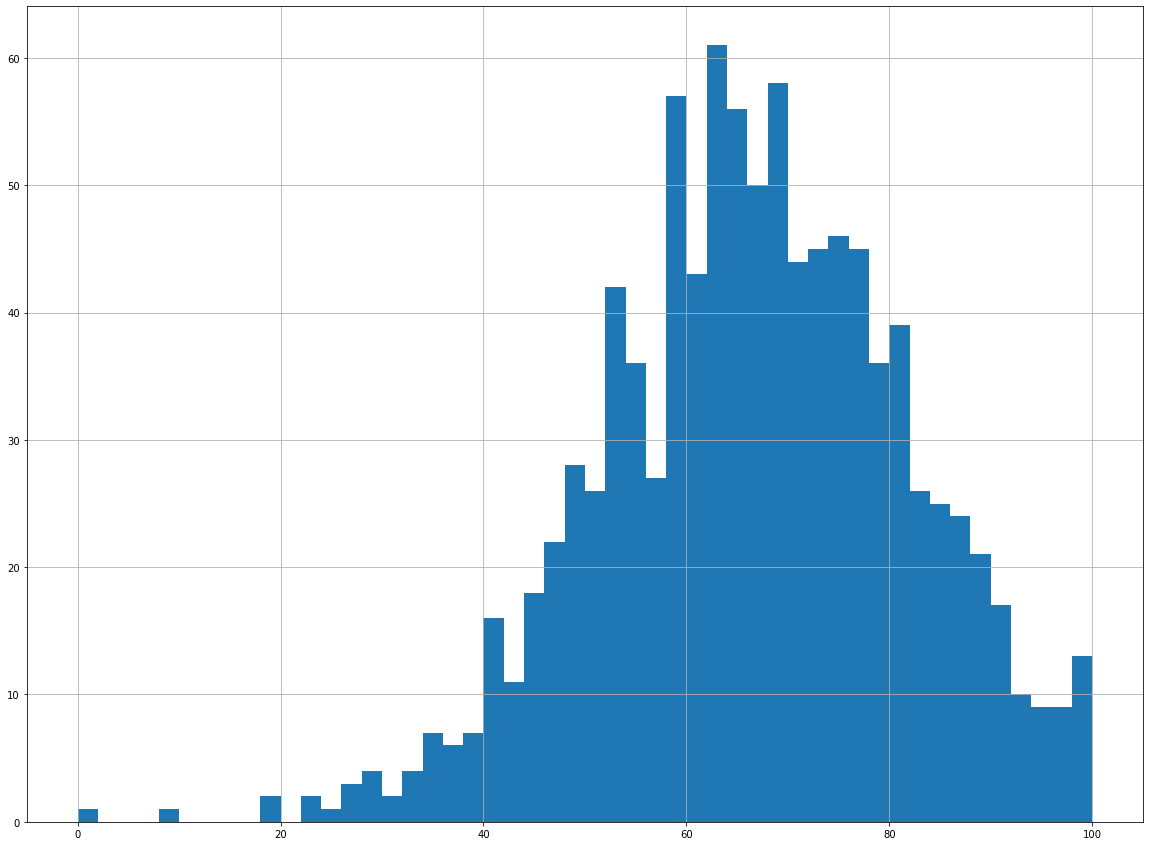

In [8]:
sdata["math score"].hist(bins=50, figsize=(20,15))
plt.show()

<BarContainer object of 1000 artists>

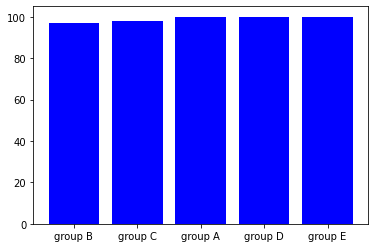

In [9]:
plt.bar("race/ethnicity", "math score", data = sdata, color = "blue")

In [10]:
correlation = sdata.corr()
correlation["math score"].sort_values(ascending=False)

math score       1.000000
reading score    0.817580
writing score    0.802642
Name: math score, dtype: float64

In [11]:
sdata["average score"] = (sdata["math score"] + sdata["reading score"] + sdata["writing score"])/3


In [12]:
sdata["average score"]

0      72.666667
1      82.333333
2      92.666667
3      49.333333
4      76.333333
         ...    
995    94.000000
996    57.333333
997    65.000000
998    74.333333
999    83.000000
Name: average score, Length: 1000, dtype: float64

In [13]:
correlation = sdata.corr()
correlation["average score"].sort_values(ascending=False)

average score    1.000000
reading score    0.970331
writing score    0.965667
math score       0.918746
Name: average score, dtype: float64

In [14]:
sdata.sem(axis = 0)

math score       0.479499
reading score    0.461699
writing score    0.480529
average score    0.450856
dtype: float64

In [15]:
sdata.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   gender                       1000 non-null   object 
 1   race/ethnicity               1000 non-null   object 
 2   parental level of education  1000 non-null   object 
 3   lunch                        1000 non-null   object 
 4   test preparation course      1000 non-null   object 
 5   math score                   1000 non-null   int64  
 6   reading score                1000 non-null   int64  
 7   writing score                1000 non-null   int64  
 8   average score                1000 non-null   float64
dtypes: float64(1), int64(3), object(5)
memory usage: 70.4+ KB


In [16]:
sdata["test preparation course"].value_counts()

none         642
completed    358
Name: test preparation course, dtype: int64

In [17]:
sdata.corr(method="pearson")


,math score,reading score,writing score,average score
math score,1.000000,0.817580,0.802642,0.918746
reading score,0.817580,1.000000,0.954598,0.970331
writing score,0.802642,0.954598,1.000000,0.965667
average score,0.918746,0.970331,0.965667,1.000000


In [18]:
sdata["test preparation course"] = sdata["test preparation course"].replace('none',0)
sdata["test preparation course"] = sdata["test preparation course"].replace('completed',1)

In [19]:
sdata["test preparation course"]

0      0
1      1
2      0
3      0
4      0
      ..
995    1
996    0
997    1
998    1
999    0
Name: test preparation course, Length: 1000, dtype: int64

In [20]:
sdata.loc[[0]]

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,average score
0,female,group B,bachelor's degree,standard,0,72,72,74,72.666667


In [21]:
sdata["parental level of education"].value_counts()

some college          226
associate's degree    222
high school           196
some high school      179
bachelor's degree     118
master's degree        59
Name: parental level of education, dtype: int64

In [22]:
sdata["parental level of education"] = sdata["parental level of education"].replace('some high school',0)
sdata["parental level of education"] = sdata["parental level of education"].replace('high school',1)
sdata["parental level of education"] = sdata["parental level of education"].replace('some college',2)
sdata["parental level of education"] = sdata["parental level of education"].replace("associate's degree", 3)
sdata["parental level of education"] = sdata["parental level of education"].replace("bachelor's degree" ,4)
sdata["parental level of education"] = sdata["parental level of education"].replace("master's degree",5)








In [23]:
sdata.loc[[0]]


,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,average score
0,female,group B,4,standard,0,72,72,74,72.666667


In [24]:
sdata["gender"] = sdata["gender"].replace('male',0)
sdata["gender"] = sdata["gender"].replace('female',1)


In [25]:
sdata["lunch"].value_counts()

standard        645
free/reduced    355
Name: lunch, dtype: int64

In [26]:
sdata["lunch"] = sdata["lunch"].replace('standard',0)
sdata["lunch"] = sdata["lunch"].replace('free/reduced',1)


In [27]:
sdata["race/ethnicity"] = sdata["race/ethnicity"].replace('group A',0)
sdata["race/ethnicity"] = sdata["race/ethnicity"].replace('group B',1)
sdata["race/ethnicity"] = sdata["race/ethnicity"].replace('group C',2)
sdata["race/ethnicity"] = sdata["race/ethnicity"].replace('group D',3)
sdata["race/ethnicity"] = sdata["race/ethnicity"].replace('group E',4)

In [28]:
sdata.loc[[0]]


,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,average score
0,1,1,4,0,0,72,72,74,72.666667


In [29]:
for x in sdata.columns:
         
    print(x+" coefficient",sdata["math score"].corr(sdata[x],method="pearson"))

#Correlations for math score

gender coefficient -0.16798223810035587
race/ethnicity coefficient 0.216415448298089
parental level of education coefficient 0.15943181815735602
lunch coefficient -0.35087664559186105
test preparation course coefficient 0.17770246930439487
math score coefficient 0.9999999999999999
reading score coefficient 0.8175796636720539
writing score coefficient 0.8026420459498085
average score coefficient 0.9187457588383449


In [30]:
for x in sdata.columns:
         
    print(x+" coefficient",sdata["reading score"].corr(sdata[x],method="pearson"))

#Correlations for reading score

gender coefficient 0.24431260787747194
race/ethnicity coefficient 0.14525262214153503
parental level of education coefficient 0.19090826476420364
lunch coefficient -0.22956032166228124
test preparation course coefficient 0.24178043354875162
math score coefficient 0.8175796636720539
reading score coefficient 1.0
writing score coefficient 0.954598077146248
average score coefficient 0.9703306887176947


In [31]:
for x in sdata.columns:
         
    print(x+" coefficient",sdata["writing score"].corr(sdata[x],method="pearson"))

#Correlations for writing score

gender coefficient 0.3012249355007126
race/ethnicity coefficient 0.16569051050724576
parental level of education coefficient 0.23671517332205247
lunch coefficient -0.24576867638421876
test preparation course coefficient 0.31294628448595657
math score coefficient 0.8026420459498084
reading score coefficient 0.954598077146248
writing score coefficient 1.0
average score coefficient 0.9656672374542069


In [32]:


for x in sdata.columns:
         
    print(x+" coefficient",sdata["average score"].corr(sdata[x],method="pearson"))

#Correlations for average score

gender coefficient 0.1308612298848538
race/ethnicity coefficient 0.18516836222429708
parental level of education coefficient 0.2057846688566186
lunch coefficient -0.29006402187118785
test preparation course coefficient 0.25670970665622256
math score coefficient 0.9187457588383448
reading score coefficient 0.9703306887176947
writing score coefficient 0.9656672374542069
average score coefficient 1.0


In [33]:
from sklearn.datasets import fetch_openml 

In [47]:
from sklearn.linear_model import LinearRegression
#model = LinearRegression()
#model.fit(sdata["average score"], sdata["test preparation course"])  # where X is your feature data and y is your target
#reg.score(sdata["average score"].corr(sdata["test preparation course"],method="pearson"), y)  # R^2 value

#reg.coef_  # slope coeficients

#reg.intercept_  # intercept

from sklearn.feature_selection import SelectKBest, f_classif
temp = sdata
temp = temp.drop(["writing score"],axis=1, inplace=True)

featS = SelectKBest(f_classif, k=6)
fit = featS.fit(temp,sdata["writing score"])
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(x.columns)
featureScores = pd.concat([dfcolumns,dfscores], axis=1)
featureScores.columns = ['features', 'score']
print(featureScores.nlargest(6,'score'))




In [38]:
sdata[["reading score","writing score"]].to_csv("feat1.csv",index=False)
sdata[["reading score","writing score","math score","lunch" ]].to_csv("feat2.csv",index=False)
sdata[["reading score","writing score","math score","lunch" ,"test preparation course","parental level of education"]].to_csv("feat3.csv",index=False)

In [53]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
X_train,X_test, y_train, y_test = train_test_split(sdata, sdata["average score"])

model = LinearRegression()
model.fit(X_train,y_train)
model.predict(X_test)

cross_val_score(model, X_train, y_train, scoring="accuracy")




C:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:683: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 674, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 87, in __call__
    score = scorer._score(cached_call, estimator,
  File "C:\Anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 242, in _score
    return self._sign * self._score_func(y_true, y_pred,
  File "C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py", line 63, in inner_f
    return f(*args, **kwargs)
  File "C:\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py", line 202, in accuracy_score
    y_type, y_true, y_pred = _check_targets(y_true, y_pred)
  File "C:\Anaconda3\lib\site-packages\sklearn\metrics\_c

array([nan, nan, nan, nan, nan])